## Helper functions

In [2]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [3]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [4]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [ ]:
def count_keys(lst):

    counts = {}
    for item in lst:
        if isinstance(item, list):
            sub_counts = count_keys(item)
            for key, value in sub_counts.items():
                counts[key] = counts.get(key, 0) + value
        else:
            counts[item] = counts.get(item, 0) + 1
    return counts

In [209]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    scores_with_indicator = []
    for i,item in enumerate(new_data[dataset][split]):
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue

        if flag == True:
            data = new_dict
            
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                data['lowest'] = None
                data['average'] = None
                lowest_obj.append(None)
                print("non_int data found... continue")
                print(data)

            scores_per_item.append(data)
            scores_with_indicator.append((data,item['generated_cot'][0]['answers'][0]['correct_answer']))

    #filter for strings
    lowest_tuples = []
    for i in range(len(lowest_obj)):
        lowest_tuples.append((lowest_obj[i],scores_with_indicator[i][1]))
    print(lowest_tuples[0])
    filtered_lowest_tuples = [score_tuple for score_tuple in lowest_tuples if not any(isinstance(value, str) for value in score_tuple[0])]
         
    return scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator

In [204]:
[score_tuple for score_tuple in scores_with_indicator if not any(isinstance(value, str) for value in score_tuple[0].values())]

[({'obj_1': 100,
   'obj_2': 100,
   'obj_3': 100,
   'obj_4': 100,
   'obj_5': 100,
   'obj_6': 100,
   'obj_7': 100,
   'obj_8': 100,
   'obj_9': 100,
   'obj_10': 100,
   'obj_11': 100,
   'lowest': 100,
   'average': 100.0},
  False),
 ({'obj_1': 100,
   'obj_2': 100,
   'obj_3': 100,
   'obj_4': 100,
   'obj_5': 100,
   'obj_6': 100,
   'obj_7': 90,
   'obj_8': 100,
   'obj_9': 90,
   'obj_10': 100,
   'obj_11': 100,
   'lowest': 90,
   'average': 98.18181818181819},
  True),
 ({'obj_1': 100,
   'obj_2': 100,
   'obj_3': 100,
   'obj_4': 100,
   'obj_5': 100,
   'obj_6': 100,
   'obj_7': 90,
   'obj_8': 100,
   'obj_9': 90,
   'obj_10': 100,
   'obj_11': 100,
   'lowest': 90,
   'average': 98.18181818181819},
  True),
 ({'obj_1': 100,
   'obj_2': 100,
   'obj_3': 100,
   'obj_4': 100,
   'obj_5': 100,
   'obj_6': 100,
   'obj_7': 100,
   'obj_8': 100,
   'obj_9': 100,
   'obj_10': 100,
   'obj_11': 100,
   'lowest': 100,
   'average': 100.0},
  True),
 ({'obj_1': 100,
   'obj_2': 

In [9]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue

    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [11]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [12]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

# def avg_item_plot(scores_per_objective):  #later better axes
 
#     data = scores_per_objective
#     averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
#     sorted_data = {k: v for k, v in sorted(averaged_data.items())}

#     # Extract the keys (objectives) and values (averages) from the sorted dictionary
#     keys = sorted_data.keys()
#     values = sorted_data.values()

#     # Create a bar plot
#     plt.bar(keys, values)
#     plt.xlabel('Objectives')
#     plt.ylabel('Average')
#     # plt.ylim(7,10)
#     plt.title('Average per Objective')
#     plt.xticks(rotation=45)
#     plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))


In [13]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [210]:
from scipy.stats import mannwhitneyu

def u_test(scores_with_indicator):

    #filter for strings
    filtered_scores_with_indicator = [score_tuple for score_tuple in scores_with_indicator if not any(isinstance(value, str) for value in score_tuple[0].values())]
    

    scores, indicators= zip(*filtered_scores_with_indicator)

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    print(dict_1.keys())

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

## Run CoT

In [41]:
from cot import Collection
med_qa = Collection.from_json("med_qa_400.json")

med_qa

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    400 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [ ]:
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
med_qa.dump("med_qa_400_turbo")
med_qa.evaluate()
med_qa.dump("med_qa_400_turbo_eval")
med_qa.evaluate()

In [ ]:
# generate cohere
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "cohere",
    "api_time_interval": 1,
    "engine": "command-xlarge-nightly", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

# med_qa.dump("med_qa_zhou_cohere.json")
# med_qa.evaluate()
# med_qa.dump("med_qa_zhou_cohere.json")

In [31]:
# generate gpt-3.5-turbo
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
# med_qa.dump("med_qa_zhou.json")
# med_qa.evaluate()
# med_qa.dump("med_qa_zhou_eval.json")

Generating med_qa...


In [42]:
from cot import Collection
# med_qa = Collection.from_json("med_qa_400.json")

# generate gpt-4
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-4", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

med_qa.dump("med_qa_400_gpt4.json")
med_qa.evaluate()
med_qa.dump("med_qa_400_eval_gpt4.json")

med_qa.evaluate()

Generating med_qa...


  0%|          | 0/400 [00:00<?, ?ex/s]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Request failed due to server shutdown {
  "error": {
    "message": "Request failed due to server shutdown",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'Request failed due to server shutdown', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Fri, 02 Jun 2023 21:49:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '141', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-0314', 'openai-organization': 'medical-university-of-vienna', 'openai-processing-ms': '32142', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '200', 'x-ratelimit-limit-tokens': '40000', 'x-ratelimit-remaining-requests': '199', 'x-ratelimit-remaining-tokens': '39192', 'x-ratelimit-rese

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'gpt-4': {'None_zhou-01_kojima-A-E': 0.785}}}}}

## Template

In [43]:
path = "./final_system_messages/first_template.yaml"

## Run reflection

In [ ]:
# 3.5 on 3.5
data = med_qa
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

In [ ]:
#Other reflection were run in big_reflection_experiments.ipynb

## Evaluate reflection

In [118]:
import copy
def generate_without_none_ans(data):
    all_data = copy.deepcopy(data)
    true_data = copy.deepcopy(data)
    false_data = copy.deepcopy(data)


    false_data.evaluate()
    false_data.select_generated_cots(answer=False)
    false_data = false_data.filter(lambda x: len(x["generated_cot"])==1)

    true_data.evaluate()
    true_data.select_generated_cots(answer=True)
    true_data = true_data.filter(lambda x: len(x["generated_cot"])==1)

    full_data = false_data.merge(true_data)

    ids = full_data.dump_ids()

    # print(len(ids))

    # print(all_data)

    none_data = all_data.filter(lambda ex: ex['id'] not in ids)

    # print(none_data)

    none_ids = none_data.dump_ids()

    return all_data.filter(lambda ex: ex['id'] not in none_ids)



In [124]:
for element in c['med_qa']['test']:
    if element['generated_cot'][0]['answers'][0]['correct_answer'] is None:
        print("None found")

None found
None found
None found
None found


In [ ]:
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_100_first_gpt-4_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data_500['med_qa']['test'][0]

In [120]:
data_500 = generate_without_none_ans(data_500)
print(data_500)

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    496 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    496 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']
non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 100, 'obj_6': 100, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100}
non_int data found... continue
{'obj_1': 'The reasoning accurately breaks down the question into smaller parts and analyzes each possible outcome.', 'obj_2': 'The reasoning considers all relevant information and does not consider irrelevant information.', 'obj_3': 'The reasoning accurately interprets and incorporates the numerical info

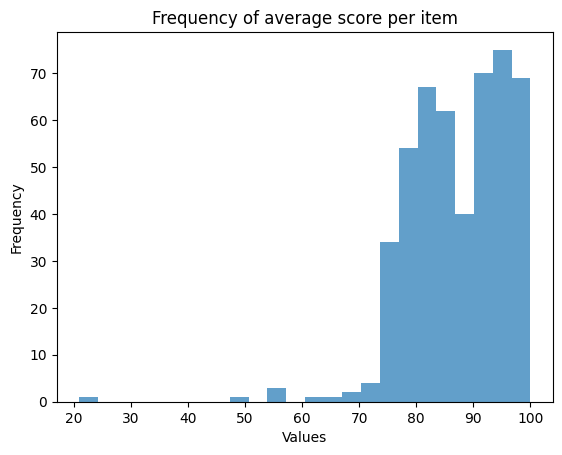

Mann-Whitney-U test
dict_keys(['average', 'obj_10', 'obj_11', 'obj_6', 'obj_5', 'obj_4', 'obj_3', 'obj_2', 'obj_8', 'obj_7', 'obj_9', 'obj_1', 'lowest'])
For average, U-statistic is 21506.50 and the p-value is 0.19
For obj_10, U-statistic is 21248.00 and the p-value is 0.25
For obj_11, U-statistic is 22332.00 and the p-value is 0.02
For obj_6, U-statistic is 21671.50 and the p-value is 0.14
For obj_5, U-statistic is 19296.50 and the p-value is 0.66
For obj_4, U-statistic is 21990.50 and the p-value is 0.08
For obj_3, U-statistic is 22626.00 and the p-value is 0.02
For obj_2, U-statistic is 21783.00 and the p-value is 0.07
For obj_8, U-statistic is 21584.50 and the p-value is 0.14
For obj_7, U-statistic is 21409.00 and the p-value is 0.21
For obj_9, U-statistic is 21129.00 and the p-value is 0.29
For obj_1, U-statistic is 20234.50 and the p-value is 0.75
For lowest, U-statistic is 20710.00 and the p-value is 0.48


Frequency where objective is lowest scored for items with false answer
{

,Average_true,Average_false,Difference
obj_1,90.190840,89.900990,0.289850
obj_2,96.335878,95.049505,1.286373
obj_3,92.748092,90.544554,2.203537
obj_4,89.592875,87.871287,1.721588
obj_5,83.307888,83.712871,-0.404983
obj_6,85.992366,84.554455,1.437911
obj_7,85.496183,83.861386,1.634797
obj_8,92.519084,91.336634,1.182450
obj_9,76.513995,75.247525,1.266470
obj_10,87.506361,86.287129,1.219233


In [187]:
#GPT-4 supervised by GPT-3.5

data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_100_first_gpt-4_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data_500 = generate_without_none_ans(data_500)
print(data_500)
data = data_500 #data_500 #is still running

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
# print("\n")
# print("Frequency where objective is lowest scored for items with false answer")
# print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
# print("\n")
# print("Frequency where objective is lowest scored for items with correct answer")
# print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
# print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
compare_true_false(scores_per_objective_true,scores_per_objective_false)

In [181]:
filtered_scores_with_indicator = [score_tuple for score_tuple in scores_with_indicator if not any(isinstance(value, str) for value in score_tuple[0].values())]

In [184]:
len(filtered_scores_with_indicator)

494

In [185]:
len(scores_with_indicator)

496

In [180]:
scores,indicators = zip(*scores_with_indicator)
for i,element in enumerate(scores):
        for inner_key, value in element.items():
            if isinstance(value,str):
                print(i,inner_key,value)

183 obj_3 N/A
407 obj_1 The reasoning accurately breaks down the question into smaller parts and analyzes each possible outcome.
407 obj_2 The reasoning considers all relevant information and does not consider irrelevant information.
407 obj_3 The reasoning accurately interprets and incorporates the numerical information provided by the user.
407 obj_4 The reasoning considers all relevant reasoning strategies and selects the most appropriate reasoning strategy, but could benefit from more detailed explanations of the biochemical processes involved.
407 obj_5 The reasoning is structured through reasoning steps, but could benefit from more sub-questions to further break down the analysis.
407 obj_6 The reasoning gives appropriate priorities to different considerations based on their relevance and importance.
407 obj_7 The reasoning lists and considers all relevant underlying assumptions.
407 obj_8 The reasoning is plausible, logically valid, sound, consistent, and coherent.
407 obj_9 The

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 70, 'obj_6': 90, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100}


Average over objectives for all items
          Average
obj_1   96.146497
obj_2   91.783439
obj_3   97.133758
obj_4   91.040340
obj_5   92.664544
obj_6   91.326964
obj_7   84.033970
obj_8   90.021231
obj_9   86.571125
obj_10  92.505308
obj_11  92.399151


Average over objectives separated by items with correct / incorrect answers
scores true: 93.73779803813933
scores false: 84.67883240355151


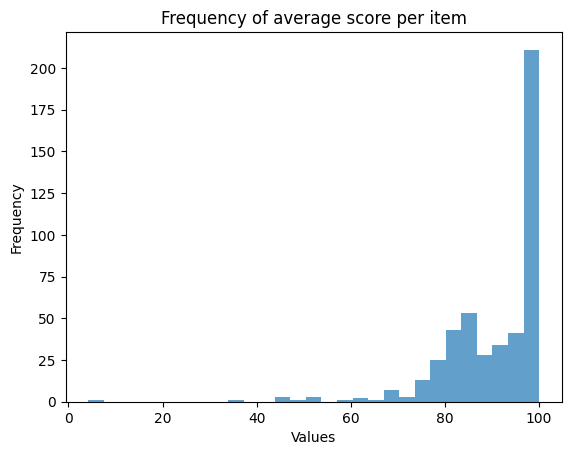

Mann-Whitney-U test
dict_keys(['average', 'obj_10', 'obj_11', 'obj_6', 'obj_5', 'obj_4', 'obj_3', 'obj_2', 'obj_8', 'obj_7', 'obj_9', 'obj_1', 'lowest'])
For average, U-statistic is 39643.00 and the p-value is 0.00
For obj_10, U-statistic is 37934.00 and the p-value is 0.00
For obj_11, U-statistic is 32909.50 and the p-value is 0.00
For obj_6, U-statistic is 36353.50 and the p-value is 0.00
For obj_5, U-statistic is 34523.50 and the p-value is 0.00
For obj_4, U-statistic is 38393.00 and the p-value is 0.00
For obj_3, U-statistic is 28375.50 and the p-value is 0.01
For obj_2, U-statistic is 39038.00 and the p-value is 0.00
For obj_8, U-statistic is 41039.50 and the p-value is 0.00
For obj_7, U-statistic is 36781.50 and the p-value is 0.00
For obj_9, U-statistic is 30287.50 and the p-value is 0.00
For obj_1, U-statistic is 32533.00 and the p-value is 0.00
For lowest, U-statistic is 40165.00 and the p-value is 0.00


Frequency where objective is lowest scored for items with false answer
{

,Average_true,Average_false,Difference
obj_1,97.354949,94.157303,3.197645
obj_2,95.580205,85.533708,10.046497
obj_3,98.122867,95.505618,2.617249
obj_4,95.119454,84.325843,10.793611
obj_5,94.897611,88.988764,5.908847
obj_6,94.419795,86.235955,8.183840
obj_7,87.849829,77.752809,10.097020
obj_8,95.409556,81.151685,14.257871
obj_9,88.634812,83.174157,5.460655
obj_10,95.921502,86.882022,9.039479


In [188]:
#GPT-3.5 supervised by GPT-4

data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data_500 = generate_without_none_ans(data_500)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
print("\n")
# print("Frequency where objective is lowest scored for items with false answer")
# print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
# print("\n")
# print("Frequency where objective is lowest scored for items with correct answer")
# print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
# print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
compare_true_false(scores_per_objective_true,scores_per_objective_false)

In [150]:
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
count = 0
for element in data_500['med_qa']['test']:
    if element['generated_cot'][0]['answers'][0]['correct_answer'] is None:
        print(element['generated_cot'][0]['answers'][0]['answer'])
        count+=1
print(count)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

either B) Enoxaparin or C) Clopidogrel.
either A or B.
none of the above.
not listed. The correct next step is to confirm the diagnosis with laboratory testing and refer the patient to an infectious disease specialist for further management.
none of the above.
either B) Calcium oxalate crystals or C) Hyaline casts.
either C) Systematic desensitization or D) Cognitive behavioral therapy.
A and B.
F) None of the above.
either B) Neisseria gonorrhoeae or C) Chlamydia trachomatis.
none of the above.
B or D.
none of the above.
none of the above.
none of the above.
B and C.
none of the above.
not listed and the best option would be a blood test for sexually transmitted infections.
either D or E.
none of the above.
not listed.
none of the above.
none of the above.
23


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
{'id': 'med_qa_test_828', 'ref_id': '', 'question': "A 57-year-old homeless man is brought to the emergency department because of several episodes of hematemesis in the past 24 hours. His vital signs include a temperature of 37.1°C (98.8°F), pulse of 95/min, and blood pressure of 85/60 mm Hg. On physical examination, he appears confused and unable to give a complete history. He is noted to have jaundice, palpable firm liver, mild splenomegaly, and shifting dullness consistent with the presence of ascites. Liver function tests are as follows:\nSerum aspartate aminotransferase (AST)  97 U/L\nSerum alanine aminotransferase (ALT) 40 U/L\nSerum albumin 2.5 g/dL\nTotal bilirubin 3 mg/dL\nProthrombin time 20 seconds\nWhich of the following is the most likely cause of this patient's illness?", 'type': 'multiplechoice', 'choices': ['Metabolic disorder', 'Autoimmune liver disease', 'Substance abuse', 'Obesity', ' Hepatic venous outflow obstruction'], 'context': '', 'cot': [], 

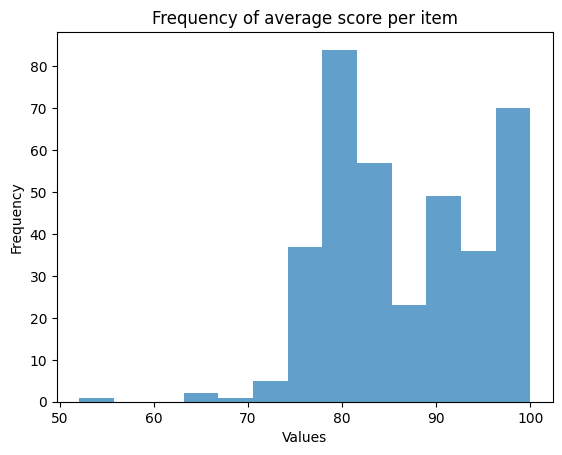

Mann-Whitney-U test
dict_keys(['average', 'obj_10', 'obj_11', 'obj_6', 'obj_5', 'obj_4', 'obj_3', 'obj_2', 'obj_8', 'obj_7', 'obj_9', 'obj_1', 'lowest'])
For average, U-statistic is 19487.50 and the p-value is 0.00
For obj_10, U-statistic is 18866.00 and the p-value is 0.01
For obj_11, U-statistic is 18908.50 and the p-value is 0.00
For obj_6, U-statistic is 18843.50 and the p-value is 0.01
For obj_5, U-statistic is 18536.50 and the p-value is 0.03
For obj_4, U-statistic is 19607.00 and the p-value is 0.00
For obj_3, U-statistic is 18656.50 and the p-value is 0.02
For obj_2, U-statistic is 18262.00 and the p-value is 0.04
For obj_8, U-statistic is 19242.00 and the p-value is 0.00
For obj_7, U-statistic is 18759.00 and the p-value is 0.02
For obj_9, U-statistic is 18486.00 and the p-value is 0.04
For obj_1, U-statistic is 18710.00 and the p-value is 0.02
For lowest, U-statistic is 18712.50 and the p-value is 0.02


Frequency where objective is lowest scored for items with false answer
{

,Average_true,Average_false,Difference
obj_1,89.680851,87.285714,2.395137
obj_2,95.808511,94.785714,1.022796
obj_3,91.021277,88.928571,2.092705
obj_4,89.021277,85.892857,3.128419
obj_5,83.106383,80.392857,2.713526
obj_6,86.063830,83.464286,2.599544
obj_7,85.042553,82.107143,2.935410
obj_8,92.425532,90.285714,2.139818
obj_9,77.936170,75.250000,2.686170
obj_10,87.829787,85.500000,2.329787


In [189]:
#GPT-3.5 supervised by GPT-3.5

data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data_500 = generate_without_none_ans(data_500)
data = data_500

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
# print("\n")
# print("Frequency where objective is lowest scored for items with false answer")
# print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
# print("\n")
# print("Frequency where objective is lowest scored for items with correct answer")
# print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
# print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
compare_true_false(scores_per_objective_true,scores_per_objective_false)

In [125]:
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
for element in data_500['med_qa']['test']:
    if element['generated_cot'][0]['answers'][0]['correct_answer'] is None:
        print("None found")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

None found
None found
None found
None found


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]



Average over objectives for all items
          Average
obj_1   99.465726
obj_2   97.651210
obj_3   99.818548
obj_4   98.356855
obj_5   99.143145
obj_6   98.417339
obj_7   89.858871
obj_8   97.872984
obj_9   92.993952
obj_10  98.971774
obj_11  98.387097


Average over objectives separated by items with correct / incorrect answers
scores true: 97.20173497388687
scores false: 94.62577026933462


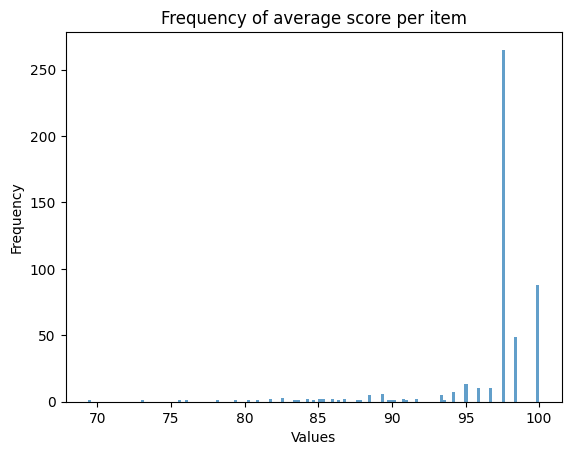

Mann-Whitney-U test
dict_keys(['average', 'obj_10', 'obj_11', 'obj_6', 'obj_5', 'obj_4', 'obj_3', 'obj_2', 'obj_8', 'obj_7', 'obj_9', 'obj_1', 'lowest'])
For average, U-statistic is 24702.50 and the p-value is 0.00
For obj_10, U-statistic is 22587.50 and the p-value is 0.00
For obj_11, U-statistic is 21230.50 and the p-value is 0.00
For obj_6, U-statistic is 23916.50 and the p-value is 0.00
For obj_5, U-statistic is 21667.00 and the p-value is 0.00
For obj_4, U-statistic is 23153.50 and the p-value is 0.00
For obj_3, U-statistic is 20095.00 and the p-value is 0.30
For obj_2, U-statistic is 23967.00 and the p-value is 0.00
For obj_8, U-statistic is 24165.50 and the p-value is 0.00
For obj_7, U-statistic is 24568.50 and the p-value is 0.00
For obj_9, U-statistic is 20227.50 and the p-value is 0.80
For obj_1, U-statistic is 21623.00 and the p-value is 0.00
For lowest, U-statistic is 24266.50 and the p-value is 0.00


Frequency where objective is lowest scored for items with false answer
{

,Average_true,Average_false,Difference
obj_1,99.658228,98.712871,0.945357
obj_2,98.354430,94.900990,3.453440
obj_3,99.924051,99.405941,0.518110
obj_4,98.924051,96.138614,2.785437
obj_5,99.316456,98.465347,0.851109
obj_6,99.012658,96.089109,2.923549
obj_7,90.708861,86.534653,4.174207
obj_8,98.696203,94.653465,4.042737
obj_9,93.050633,92.772277,0.278356
obj_10,99.341772,97.524752,1.817020


In [190]:
# GPT-4 supervised by GPT-4
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data_500 = generate_without_none_ans(data_500)
data = data_500
print("\n")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

#print("Average over objectives separated by items with correct / incorrect answers") #see compare_true_false
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
# print("\n")
# print("Frequency where objective is lowest scored for items with false answer")
# print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
# print("\n")
# print("Frequency where objective is lowest scored for items with correct answer")
# print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
# print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("\n")
print("Compare the averages of groups with correct or incorrect answer")
compare_true_false(scores_per_objective_true,scores_per_objective_false)

In [143]:
def compare_true_false(obj_scores_true,obj_scores_false):

    averaged_true = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_true.items() if len([v for v in value if v is not None]) > 0}
    averaged_false = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_false.items() if len([v for v in value if v is not None]) > 0}


    # Convert the averaged data dictionary to a Pandas DataFrame
    df_true = pd.DataFrame.from_dict(averaged_true, orient='index', columns=['Average'])
    df_false = pd.DataFrame.from_dict(averaged_false, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df_true = df_true.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]
    df_false = df_false.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]

    # Rename the 'Average' column in each dataframe
    df_true.rename(columns={'Average': 'Average_true'}, inplace=True)
    df_false.rename(columns={'Average': 'Average_false'}, inplace=True)

    # Concatenate the dataframes horizontally along the columns
    merged_df = pd.concat([df_true, df_false], axis=1)

    merged_df['Difference'] = merged_df['Average_true'] - merged_df['Average_false']

  

    return merged_df

In [144]:
compare_true_false(scores_per_objective_true,scores_per_objective_false)



,Average_true,Average_false,Difference
obj_1,99.658228,98.712871,0.945357
obj_2,98.354430,94.900990,3.453440
obj_3,99.924051,99.405941,0.518110
obj_4,98.924051,96.138614,2.785437
obj_5,99.316456,98.465347,0.851109
obj_6,99.012658,96.089109,2.923549
obj_7,90.708861,86.534653,4.174207
obj_8,98.696203,94.653465,4.042737
obj_9,93.050633,92.772277,0.278356
obj_10,99.341772,97.524752,1.817020


## results indicative of true/false?

In [152]:
average_per_item

[100.0,
 90.9090909090909,
 100.0,
 97.55244755244756,
 97.55244755244756,
 73.84615384615384,
 100.0,
 91.81818181818183,
 100.0,
 97.55244755244756,
 95.10489510489509,
 97.55244755244756,
 95.94405594405595,
 88.46153846153847,
 86.78321678321679,
 91.74825174825175,
 79.7202797202797,
 100.0,
 97.55244755244756,
 85.10489510489509,
 100.0,
 97.55244755244756,
 86.85314685314685,
 97.55244755244756,
 83.42657342657343,
 98.39160839160839,
 97.55244755244756,
 100.0,
 98.39160839160839,
 89.23076923076923,
 97.55244755244756,
 95.10489510489509,
 91.74825174825175,
 100.0,
 98.39160839160839,
 95.10489510489509,
 82.5874125874126,
 90.06993006993008,
 95.10489510489509,
 100.0,
 96.7132867132867,
 97.55244755244756,
 97.55244755244756,
 97.55244755244756,
 75.17482517482517,
 100.0,
 82.23776223776223,
 95.94405594405595,
 71.32867132867133,
 97.55244755244756,
 100.0,
 80.97902097902099,
 100.0,
 100.0,
 97.55244755244756,
 100.0,
 92.5874125874126,
 97.55244755244756,
 97.552447552

In [154]:

item_correct = []
for item in data['med_qa']['test']:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

# Example lists of scores and indicators
scores = average_per_item
indicators = item_correct

df = pd.DataFrame({'Score': scores, 'Indicator': indicators})
df



ValueError: All arrays must be of the same length

In [159]:
scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
scores_true

[100.0,
 100.0,
 97.55244755244756,
 97.55244755244756,
 100.0,
 91.81818181818183,
 100.0,
 97.55244755244756,
 97.55244755244756,
 91.74825174825175,
 100.0,
 97.55244755244756,
 85.10489510489509,
 100.0,
 97.55244755244756,
 97.55244755244756,
 97.55244755244756,
 100.0,
 98.39160839160839,
 89.23076923076923,
 97.55244755244756,
 95.10489510489509,
 91.74825174825175,
 100.0,
 95.10489510489509,
 82.5874125874126,
 95.10489510489509,
 100.0,
 97.55244755244756,
 97.55244755244756,
 97.55244755244756,
 100.0,
 82.23776223776223,
 95.94405594405595,
 97.55244755244756,
 100.0,
 100.0,
 97.55244755244756,
 100.0,
 92.5874125874126,
 97.55244755244756,
 97.55244755244756,
 94.26573426573427,
 97.55244755244756,
 96.78321678321679,
 97.55244755244756,
 69.30069930069929,
 100.0,
 90.06993006993008,
 85.10489510489509,
 95.87412587412587,
 35.24475524475525,
 100.0,
 97.55244755244756,
 94.26573426573427,
 98.39160839160839,
 100.0,
 97.55244755244756,
 97.55244755244756,
 97.5524475524

In [ ]:
indicators

In [211]:
# Take 4 supervises 3

scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
print("\n")
# these do not work with new code 
# print("Frequency where objective is lowest scored for items with false answer")
# print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
# print("\n")
# print("Frequency where objective is lowest scored for items with correct answer")
# print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
# print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))
print("Compare the averages of groups with correct or incorrect answer")
compare_true_false(scores_per_objective_true,scores_per_objective_false)

(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], False)
Mann-Whitney-U test
dict_keys(['average', 'obj_10', 'obj_11', 'obj_6', 'obj_5', 'obj_4', 'obj_3', 'obj_2', 'obj_8', 'obj_7', 'obj_9', 'obj_1', 'lowest'])
For average, U-statistic is 24702.50 and the p-value is 0.00
For obj_10, U-statistic is 22587.50 and the p-value is 0.00
For obj_11, U-statistic is 21230.50 and the p-value is 0.00
For obj_6, U-statistic is 23916.50 and the p-value is 0.00
For obj_5, U-statistic is 21667.00 and the p-value is 0.00
For obj_4, U-statistic is 23153.50 and the p-value is 0.00
For obj_3, U-statistic is 20095.00 and the p-value is 0.30
For obj_2, U-statistic is 23967.00 and the p-value is 0.00
For obj_8, U-statistic is 24165.50 and the p-value is 0.00
For obj_7, U-statistic is 24568.50 and the p-value is 0.00
For obj_9, U-statistic is 20227.50 and the p-value is 0.80
For obj_1, U-statistic is 21623.00 and the p-value is 0.00
For lowest, U-statistic

,Average_true,Average_false,Difference
obj_1,99.658228,98.712871,0.945357
obj_2,98.354430,94.900990,3.453440
obj_3,99.924051,99.405941,0.518110
obj_4,98.924051,96.138614,2.785437
obj_5,99.316456,98.465347,0.851109
obj_6,99.012658,96.089109,2.923549
obj_7,90.708861,86.534653,4.174207
obj_8,98.696203,94.653465,4.042737
obj_9,93.050633,92.772277,0.278356
obj_10,99.341772,97.524752,1.817020
